<a href="https://colab.research.google.com/github/skyish21/Deforestation-Detection/blob/main/Classification%20of%20Fire%20Types.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Libraries

In [319]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from imblearn.over_sampling import SMOTE

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

# Metrics
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay, confusion_matrix, roc_curve, auc

## Data Loading and Collection

In [320]:
df1 = pd.read_csv('/content/modis_2021_India.csv')
df2 = pd.read_csv('/content/modis_2022_India.csv')
df3 = pd.read_csv('/content/modis_2023_India.csv')

In [321]:
df1.head()

,latitude,longitude,brightness,scan,track,acq_date,acq_time,satellite,instrument,confidence,version,bright_t31,frp,daynight,type
0,28.0993,96.9983,303.0,1.1,1.1,2021-01-01,409,Terra,MODIS,44,6.03,292.6,8.6,D,0
1,30.0420,79.6492,301.8,1.4,1.2,2021-01-01,547,Terra,MODIS,37,6.03,287.4,9.0,D,0
2,30.0879,78.8579,300.2,1.3,1.1,2021-01-01,547,Terra,MODIS,8,6.03,286.5,5.4,D,0
3,30.0408,80.0501,302.0,1.5,1.2,2021-01-01,547,Terra,MODIS,46,6.03,287.7,10.7,D,0
4,30.6565,78.9668,300.9,1.3,1.1,2021-01-01,547,Terra,MODIS,43,6.03,287.6,9.0,D,0


In [322]:
df2.head()

,latitude,longitude,brightness,scan,track,acq_date,acq_time,satellite,instrument,confidence,version,bright_t31,frp,daynight,type
0,30.1138,80.0756,300.0,1.2,1.1,2022-01-01,511,Terra,MODIS,7,6.03,288.4,7.1,D,0
1,23.7726,86.2078,306.1,1.6,1.2,2022-01-01,512,Terra,MODIS,62,6.03,293.5,10.4,D,2
2,22.2080,84.8627,304.8,1.4,1.2,2022-01-01,512,Terra,MODIS,42,6.03,293.3,5.8,D,2
3,23.7621,86.3946,306.9,1.6,1.2,2022-01-01,512,Terra,MODIS,38,6.03,295.2,9.3,D,2
4,23.6787,86.0891,303.6,1.5,1.2,2022-01-01,512,Terra,MODIS,52,6.03,293.1,7.2,D,2


In [323]:
df3.head()

,latitude,longitude,brightness,scan,track,acq_date,acq_time,satellite,instrument,confidence,version,bright_t31,frp,daynight,type
0,9.3280,77.6247,318.0,1.1,1.0,2023-01-01,821,Aqua,MODIS,62,61.03,305.0,7.6,D,0
1,10.4797,77.9378,313.8,1.0,1.0,2023-01-01,822,Aqua,MODIS,58,61.03,299.4,4.3,D,0
2,13.2478,77.2639,314.7,1.0,1.0,2023-01-01,822,Aqua,MODIS,55,61.03,302.4,4.9,D,0
3,12.2994,78.4085,314.3,1.0,1.0,2023-01-01,822,Aqua,MODIS,58,61.03,301.9,4.8,D,0
4,14.1723,75.5024,338.4,1.2,1.1,2023-01-01,823,Aqua,MODIS,88,61.03,305.3,41.5,D,0


In [324]:
# ignore_index allows continuous index number for concatenated dfs
df = pd.concat([df1, df2, df3], ignore_index=True)
df.head()

,latitude,longitude,brightness,scan,track,acq_date,acq_time,satellite,instrument,confidence,version,bright_t31,frp,daynight,type
0,28.0993,96.9983,303.0,1.1,1.1,2021-01-01,409,Terra,MODIS,44,6.03,292.6,8.6,D,0
1,30.0420,79.6492,301.8,1.4,1.2,2021-01-01,547,Terra,MODIS,37,6.03,287.4,9.0,D,0
2,30.0879,78.8579,300.2,1.3,1.1,2021-01-01,547,Terra,MODIS,8,6.03,286.5,5.4,D,0
3,30.0408,80.0501,302.0,1.5,1.2,2021-01-01,547,Terra,MODIS,46,6.03,287.7,10.7,D,0
4,30.6565,78.9668,300.9,1.3,1.1,2021-01-01,547,Terra,MODIS,43,6.03,287.6,9.0,D,0


## EDA

In [325]:
df.shape # number of rows and columns

(271217, 15)

In [326]:
df.info() # data type

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271217 entries, 0 to 271216
Data columns (total 15 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   latitude    271217 non-null  float64
 1   longitude   271217 non-null  float64
 2   brightness  271217 non-null  float64
 3   scan        271217 non-null  float64
 4   track       271217 non-null  float64
 5   acq_date    271217 non-null  object 
 6   acq_time    271217 non-null  int64  
 7   satellite   271217 non-null  object 
 8   instrument  271217 non-null  object 
 9   confidence  271217 non-null  int64  
 10  version     271217 non-null  float64
 11  bright_t31  271217 non-null  float64
 12  frp         271217 non-null  float64
 13  daynight    271217 non-null  object 
 14  type        271217 non-null  int64  
dtypes: float64(8), int64(3), object(4)
memory usage: 31.0+ MB


In [327]:
df.isna().sum() # check for null/missing values

,0
latitude,0
longitude,0
brightness,0
scan,0
track,0
acq_date,0
acq_time,0
satellite,0
instrument,0
confidence,0


In [328]:
df.columns # list of all columns

Index(['latitude', 'longitude', 'brightness', 'scan', 'track', 'acq_date',
       'acq_time', 'satellite', 'instrument', 'confidence', 'version',
       'bright_t31', 'frp', 'daynight', 'type'],
      dtype='object')

In [329]:
# .T = Transpose(rows->columns, columns-> rows)
# look at df statistics
df.describe().T

,count,mean,std,min,25%,50%,75%,max
latitude,271217.0,23.947505,4.919846,8.1362,20.9655,23.7888,27.7827,34.9734
longitude,271217.0,81.284024,6.559071,68.4526,75.8802,79.3209,84.7559,97.1044
brightness,271217.0,323.719192,14.147221,300.0000,314.5000,322.0000,330.7000,505.7000
scan,271217.0,1.421732,0.630742,1.0000,1.0000,1.2000,1.5000,4.8000
track,271217.0,1.152716,0.201943,1.0000,1.0000,1.1000,1.2000,2.0000
acq_time,271217.0,824.623755,353.966965,321.0000,648.0000,756.0000,825.0000,2202.0000
confidence,271217.0,64.065081,18.165329,0.0000,54.0000,66.0000,76.0000,100.0000
version,271217.0,21.933778,24.935515,6.0300,6.0300,6.0300,61.0300,61.0300
bright_t31,271217.0,303.499177,8.282440,267.2000,298.2000,302.5000,309.2000,400.1000
frp,271217.0,27.722058,81.017471,0.0000,8.7000,13.5000,24.5000,6961.8000


In [330]:
df.value_counts(df['type']) # give unique values counts of each target variable

,count
type,
0,257625
2,13550
3,42


In [331]:
# type 1 is missing because it stands for active volcanoes, which are not in indian sub continenet

In [332]:
# Check uniqye values and n unique for all categorical features

for col in df.columns:
  if(df[col].dtype == 'object'):
    print(f'Column {col}')
    print(f'{col}: {df[col].unique()}')
    print(f'n_unique: {df[col].nunique()}')
    print("-"*50)

Column acq_date
acq_date: ['2021-01-01' '2021-01-02' '2021-01-03' ... '2023-12-29' '2023-12-30'
 '2023-12-31']
n_unique: 1088
--------------------------------------------------
Column satellite
satellite: ['Terra' 'Aqua']
n_unique: 2
--------------------------------------------------
Column instrument
instrument: ['MODIS']
n_unique: 1
--------------------------------------------------
Column daynight
daynight: ['D' 'N']
n_unique: 2
--------------------------------------------------


## Visualization

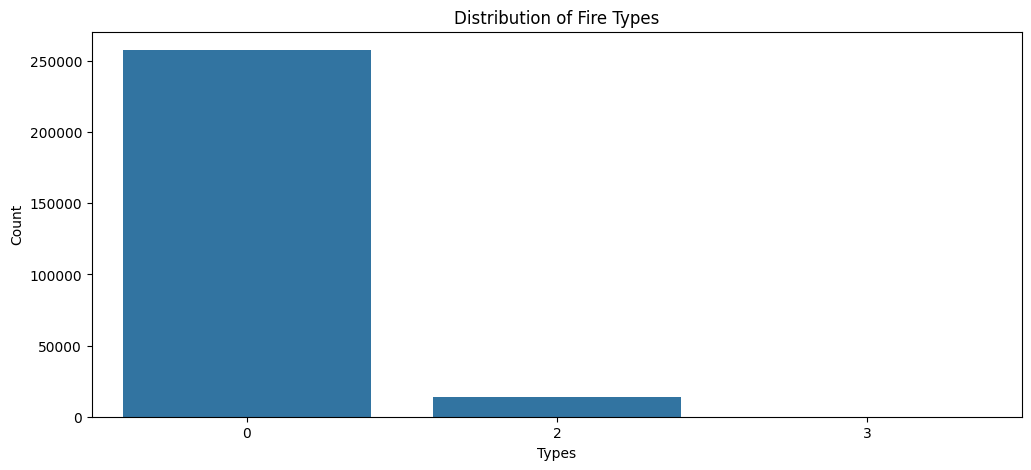

In [333]:
# Count plot for Types column
plt.figure(figsize=(12,5))
plt.title('Distribution of Fire Types')
sns.countplot(data=df, x='type')
plt.xlabel('Types')
plt.ylabel('Count')
plt.show()

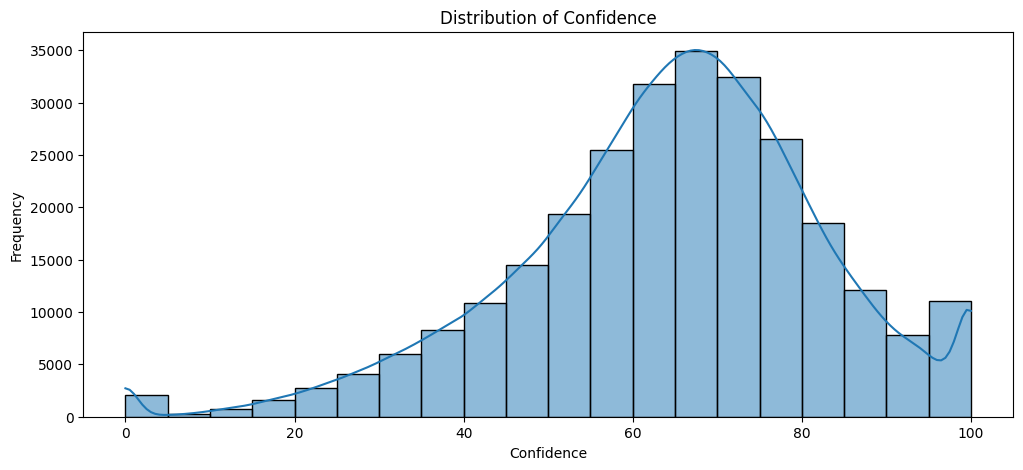

In [334]:
# Histogram of "Confidence"
plt.figure(figsize=(12,5))
plt.title('Distribution of Confidence')
sns.histplot(df['confidence'], bins=20, kde=True)
plt.xlabel('Confidence')
plt.ylabel('Frequency')
plt.show()

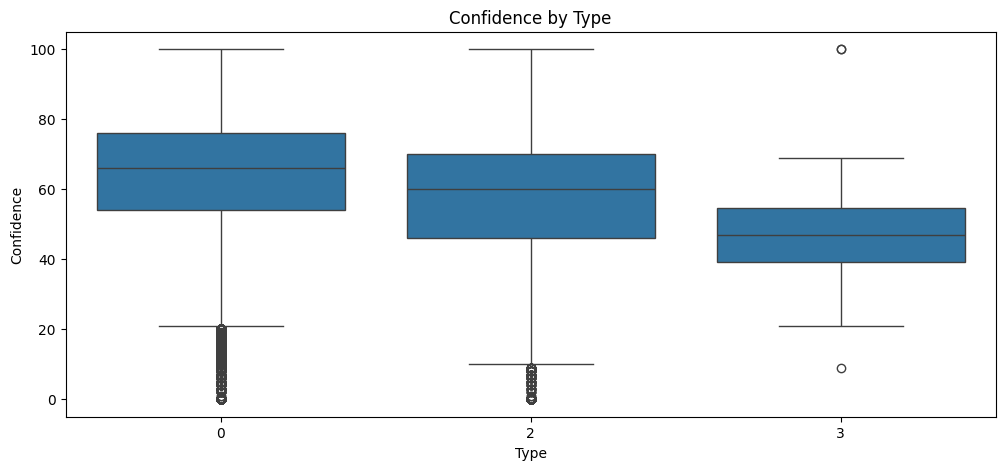

In [335]:
# Box plot for 'Confidence' by 'Type'
plt.figure(figsize=(12,5))
plt.title('Confidence by Type')
sns.boxplot(data=df, x='type', y='confidence')
plt.xlabel('Type')
plt.ylabel('Confidence')
plt.show()

/tmp/ipython-input-336-2059627347.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


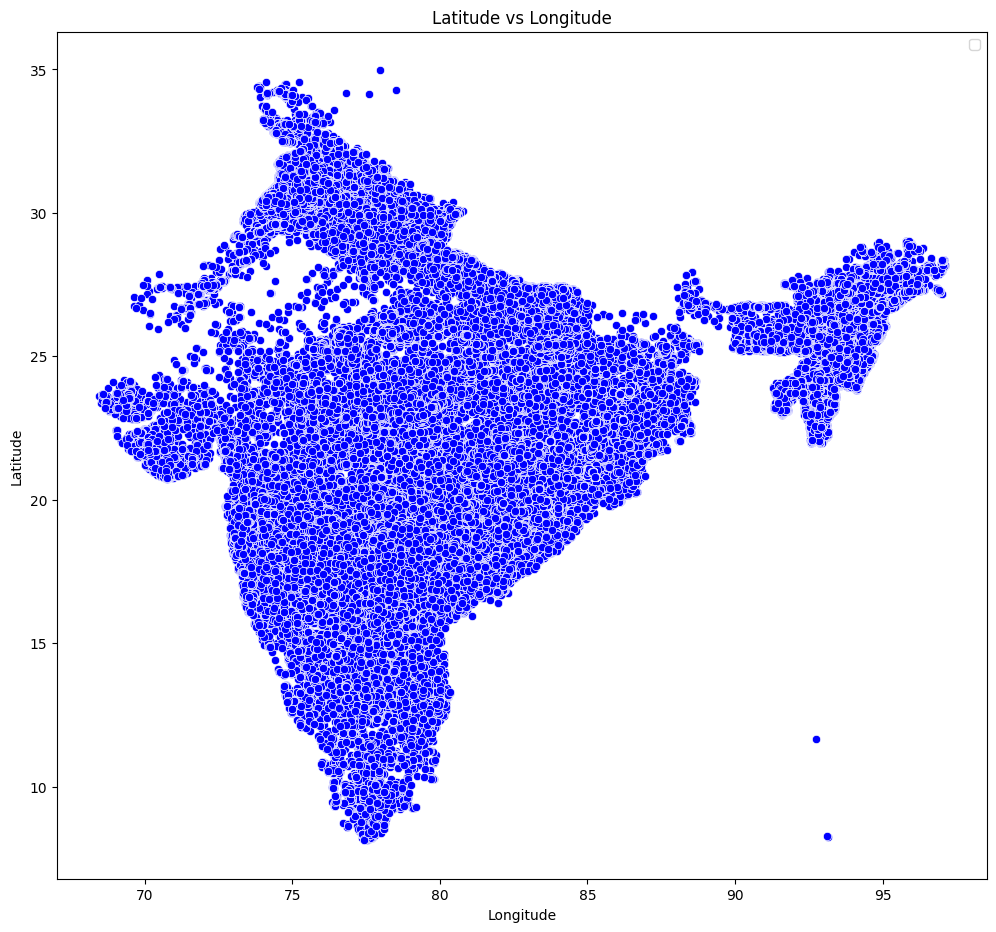

In [336]:
# Scatter PLot of 'latitude' vs 'longitue'
plt.figure(figsize=(12,11))
plt.title('Latitude vs Longitude')
sns.scatterplot(data=df, x='longitude', y='latitude', color='blue')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.show()

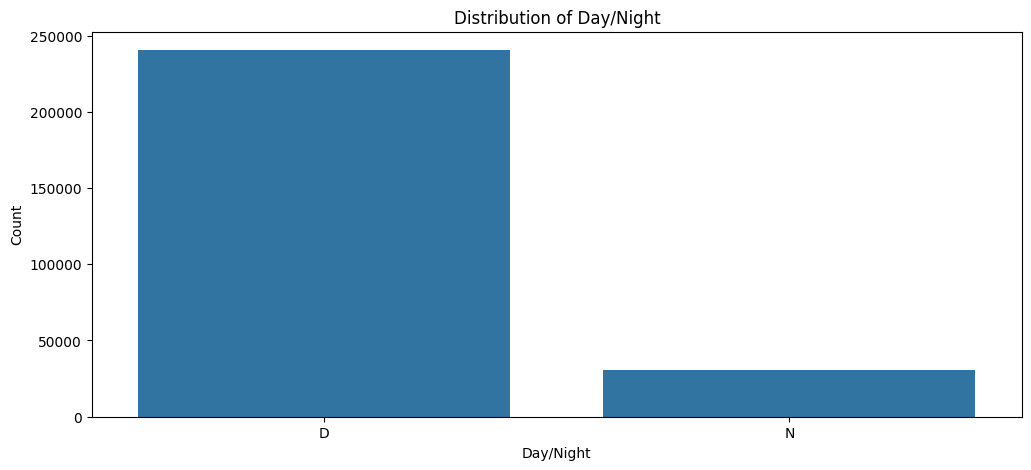

In [337]:
# Count plot based on 'daynight'
plt.figure(figsize=(12,5))
plt.title('Distribution of Day/Night')
sns.countplot(data=df, x='daynight')
plt.xlabel('Day/Night')
plt.ylabel('Count')
plt.show()

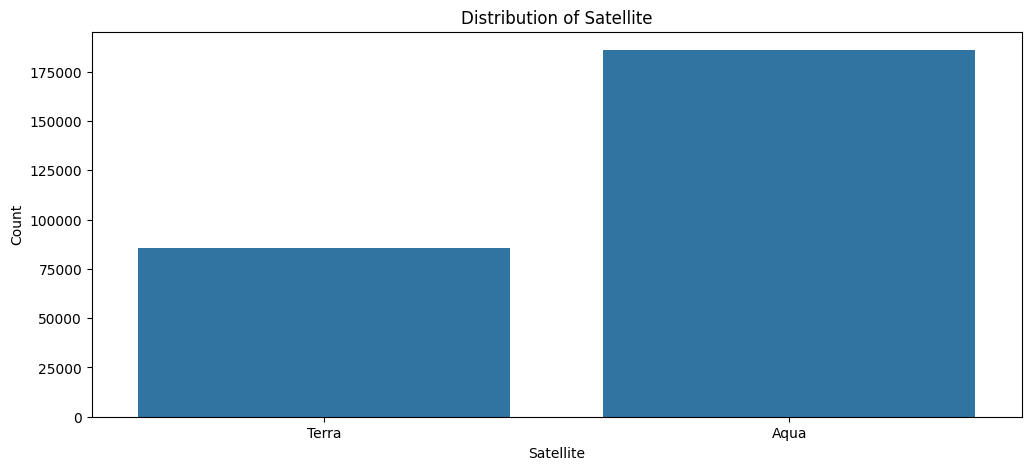

In [338]:
# Countplot based on 'satelite'
# Distribution of data provided by satelite
plt.figure(figsize=(12,5))
plt.title('Distribution of Satellite')
sns.countplot(data=df, x='satellite')
plt.xlabel('Satellite')
plt.ylabel('Count')
plt.show()

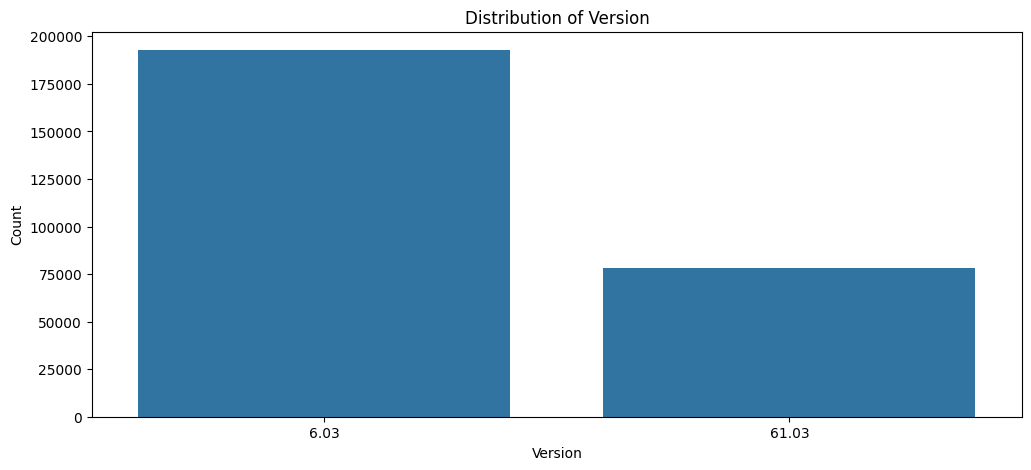

In [339]:
# Countplot based on 'Version'
plt.figure(figsize=(12,5))
plt.title('Distribution of Version')
sns.countplot(data=df, x='version')
plt.xlabel('Version')
plt.ylabel('Count')
plt.show()

Text(0.5, 1.0, 'Correlation HeatMap of Numerical Features')

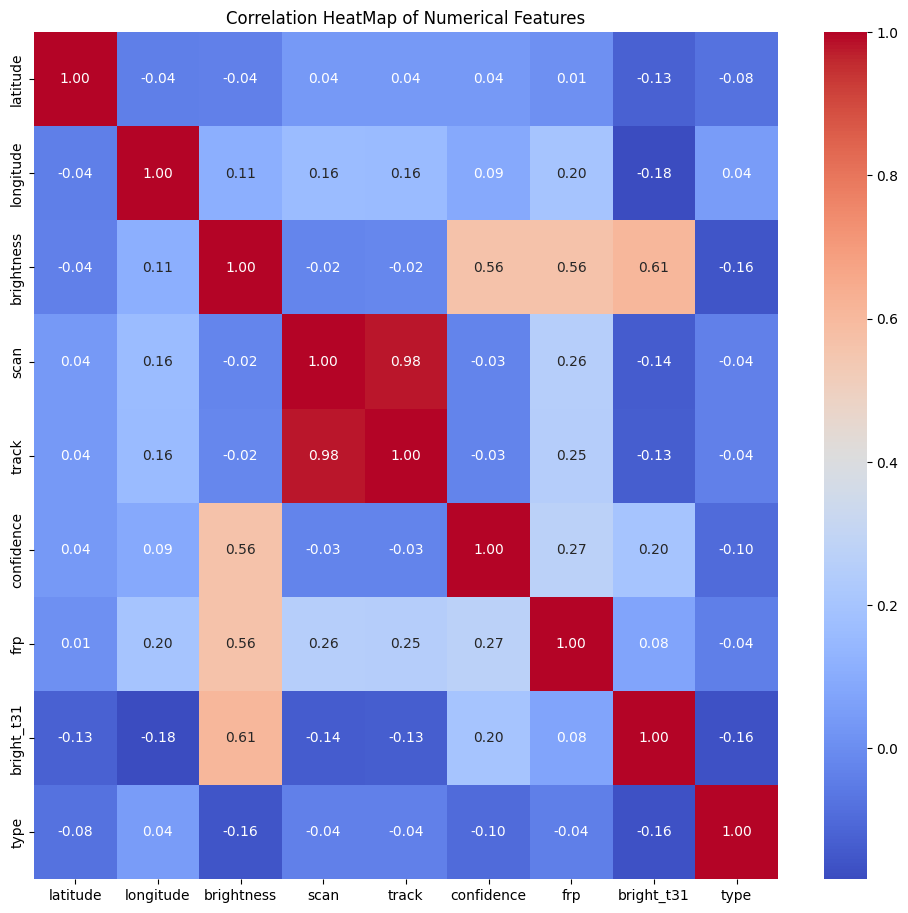

In [340]:
# Heatmap (Multivariate Analysis)
plt.figure(figsize=(12,11))
correlation_matrix = df[['latitude', 'longitude', 'brightness', 'scan', 'track', 'confidence', 'frp', 'bright_t31', 'type']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation HeatMap of Numerical Features")

In [341]:
# Get numerical columns
numerical_cols = df.select_dtypes(include=['number']).columns.tolist()

In [342]:
numerical_cols

['latitude',
 'longitude',
 'brightness',
 'scan',
 'track',
 'acq_time',
 'confidence',
 'version',
 'bright_t31',
 'frp',
 'type']

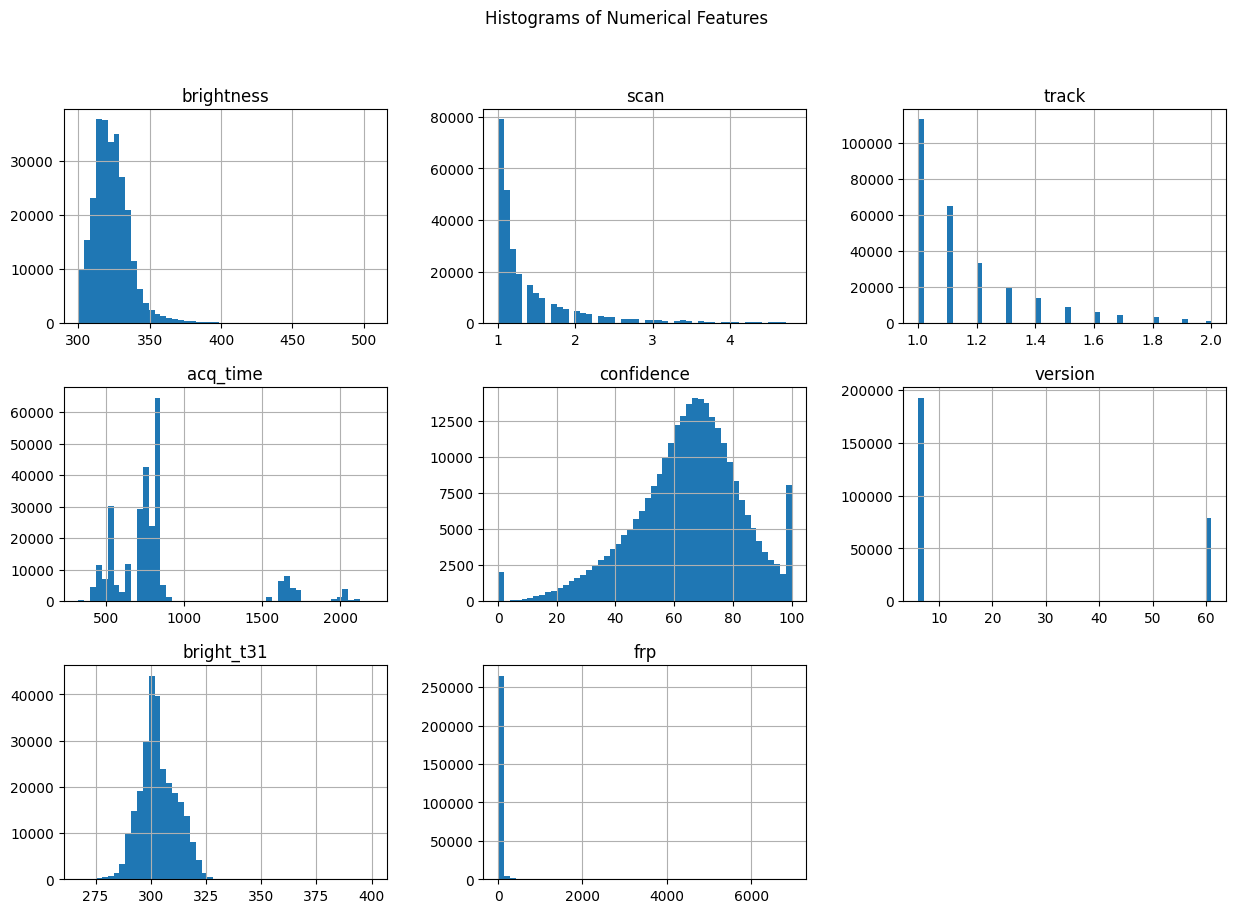

In [343]:
numerical_cols = ['brightness', 'scan', 'track', 'acq_time','confidence', 'version', 'bright_t31', 'frp']
df[numerical_cols].hist(bins=50, figsize=(15, 10))
plt.suptitle('Histograms of Numerical Features')
plt.show()

Analysing distribution for: brightness


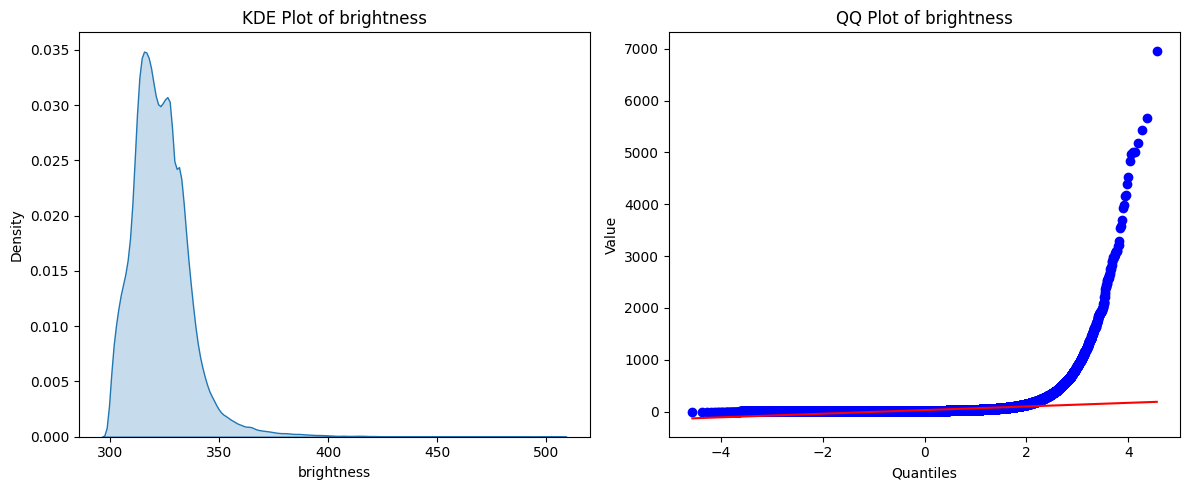

Analysing distribution for: scan


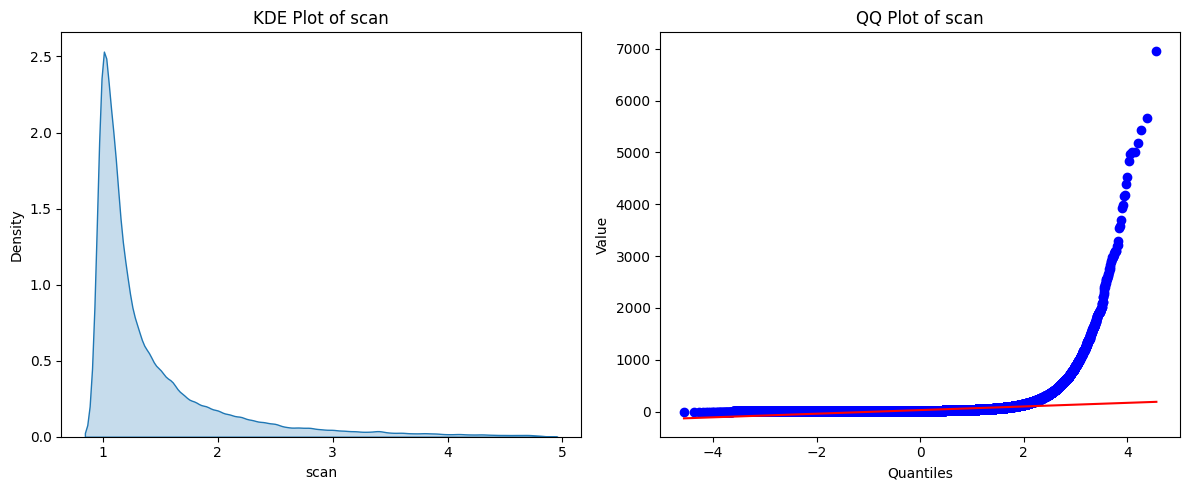

Analysing distribution for: track


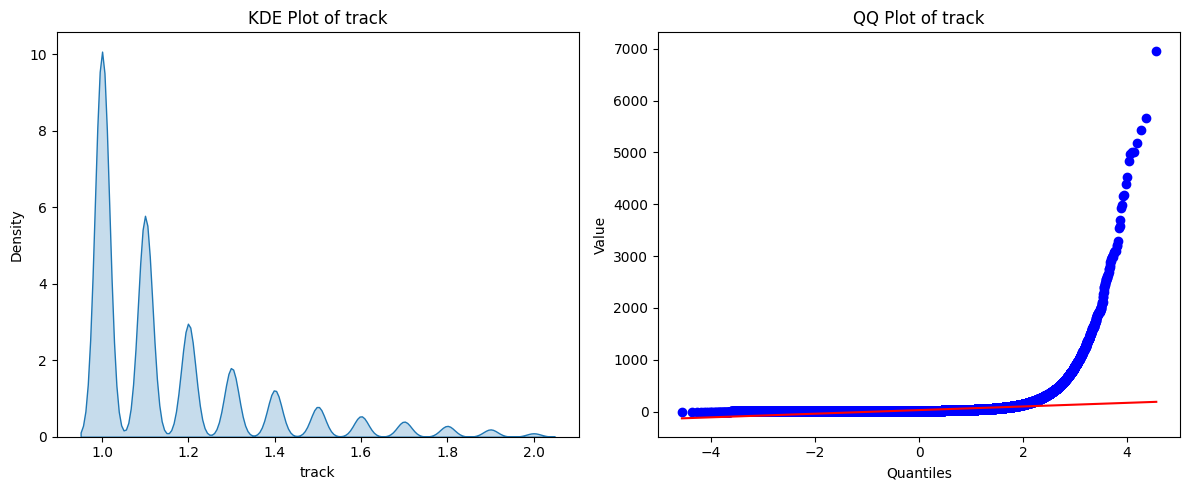

Analysing distribution for: acq_time


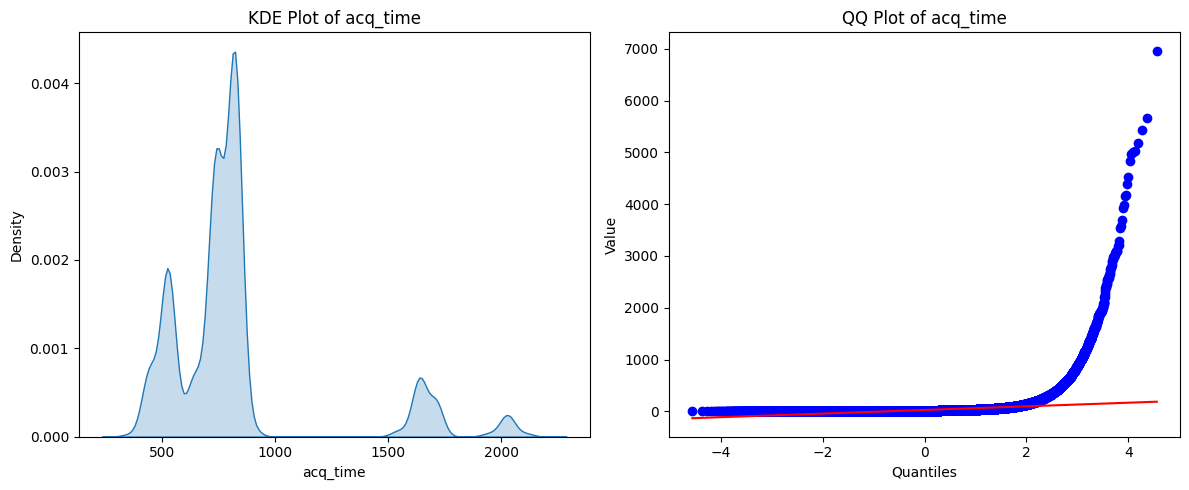

Analysing distribution for: confidence


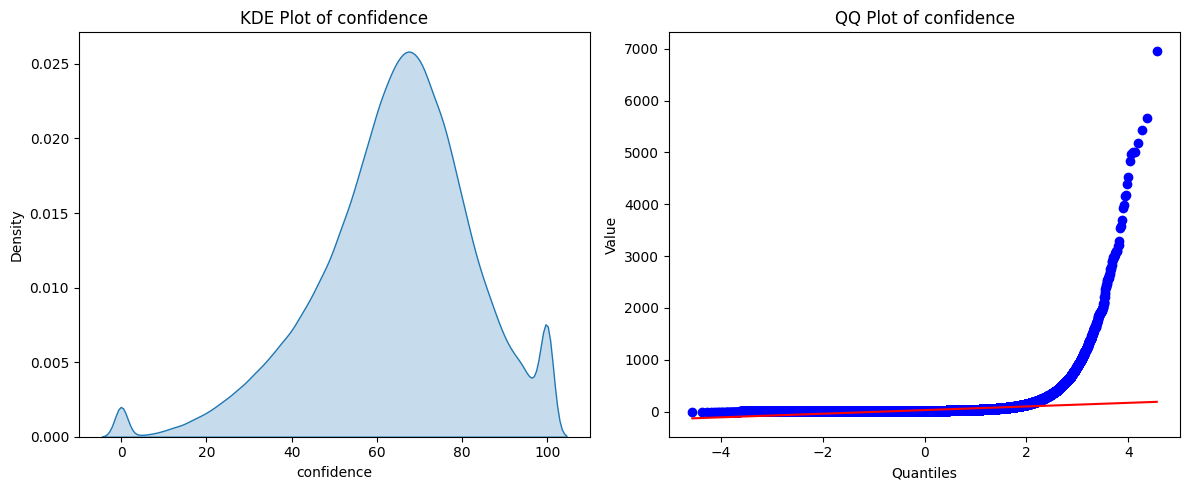

Analysing distribution for: version


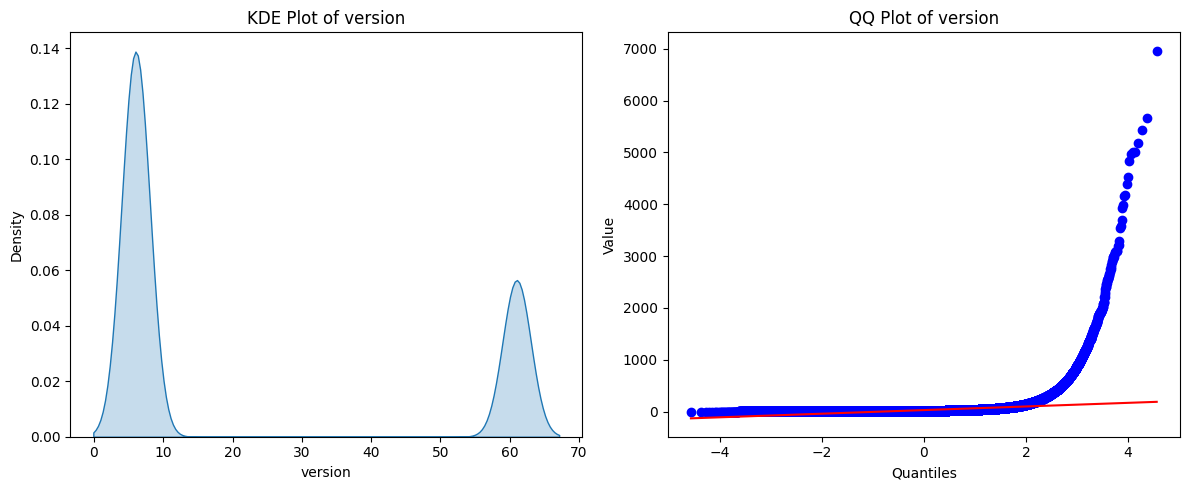

Analysing distribution for: bright_t31


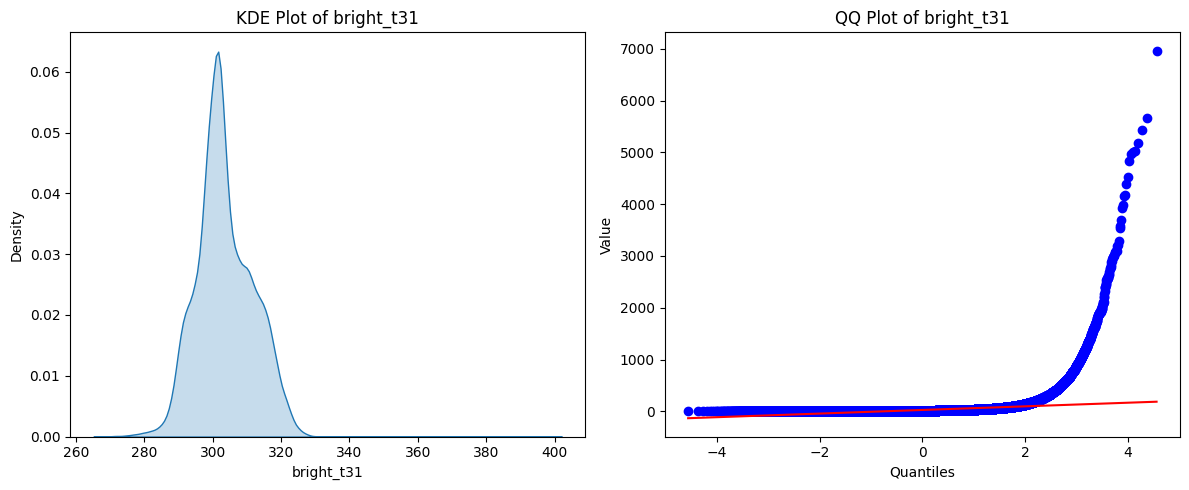

Analysing distribution for: frp


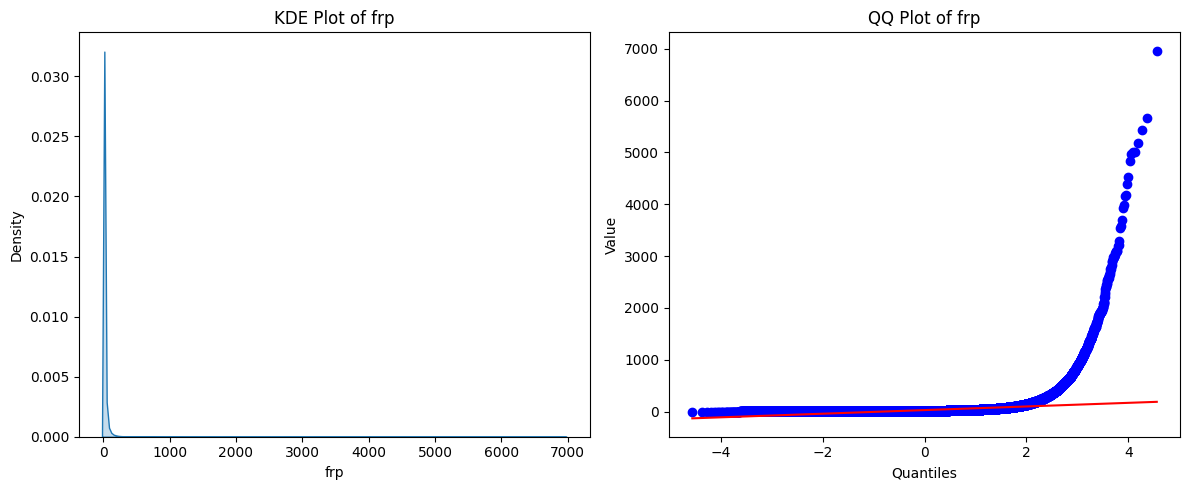

In [344]:
import statsmodels.api as sm
import scipy.stats as stats

# List of numerical features
numerical_cols

for features in numerical_cols:
  print(f'Analysing distribution for: {features}')

  # KDE Plot
  plt.figure(figsize=(12,5))

  plt.subplot(1,2,1)
  sns.kdeplot(df[features], fill=True)
  plt.title(f"KDE Plot of {features}")
  plt.xlabel(features)
  plt.ylabel('Density')

  # QQ Plot
  plt.subplot(1,2,2)
  stats.probplot(df[feature], dist="norm", plot=plt)
  plt.title(f"QQ Plot of {features}")
  plt.xlabel('Quantiles')
  plt.ylabel('Value')

  plt.tight_layout()
  plt.show()

In [345]:
# Temporal Analysis
# Convert 'acq_date' to datetime objects
df['acq_date'] = pd.to_datetime(df['acq_date'])
# Extract temporal features
df['year'] = df['acq_date'].dt.year
df['month'] = df['acq_date'].dt.month
df['dayofweek'] = df['acq_date'].dt.dayofweek
df['dayofyear'] = df['acq_date'].dt.dayofyear
df['hour'] = df['acq_time'].astype(str).str[:2].astype(int)

/tmp/ipython-input-346-2677928711.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='month', palette='viridis')


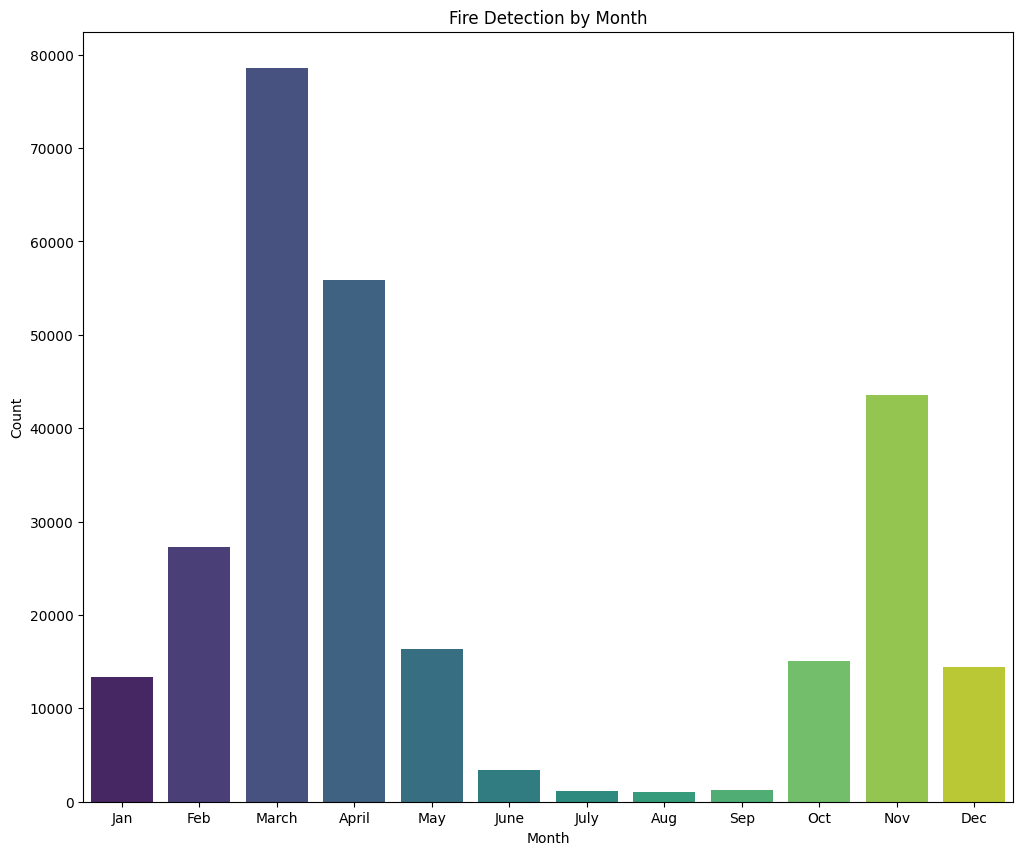

In [346]:
# Countplot for fire detection by each month, 2023
plt.figure(figsize=(12,10))
plt.title('Fire Detection by Month')
sns.countplot(data=df, x='month', palette='viridis')
plt.xticks(ticks=range(12), labels=['Jan','Feb','March','April','May','June','July','Aug','Sep','Oct','Nov','Dec'])
plt.xlabel('Month')
plt.ylabel('Count')
plt.show()

/tmp/ipython-input-347-3771374967.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='dayofweek', palette='viridis')


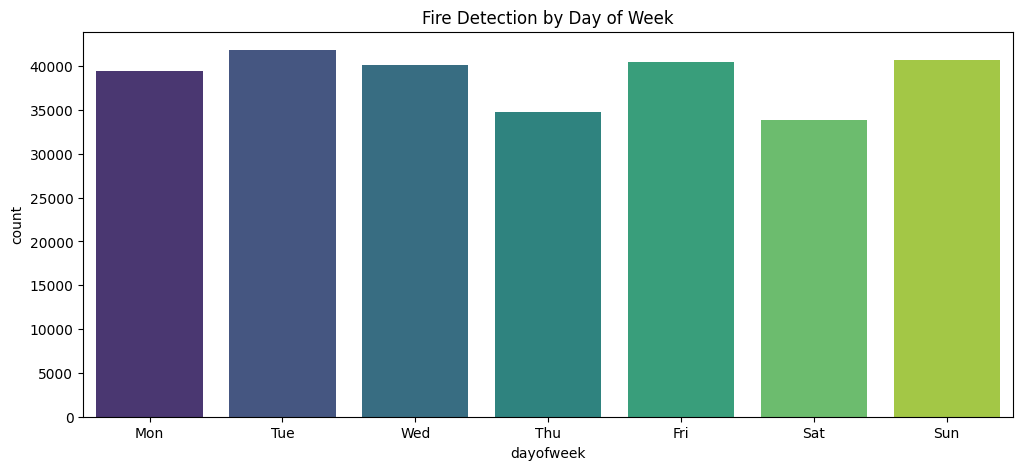

In [347]:
# Fire detection by day of week
plt.figure(figsize=(12,5))
plt.title('Fire Detection by Day of Week')
sns.countplot(data=df, x='dayofweek', palette='viridis')
plt.xticks(ticks=range(7), labels=['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])
plt.show()

## Outlier Detection and Treatment

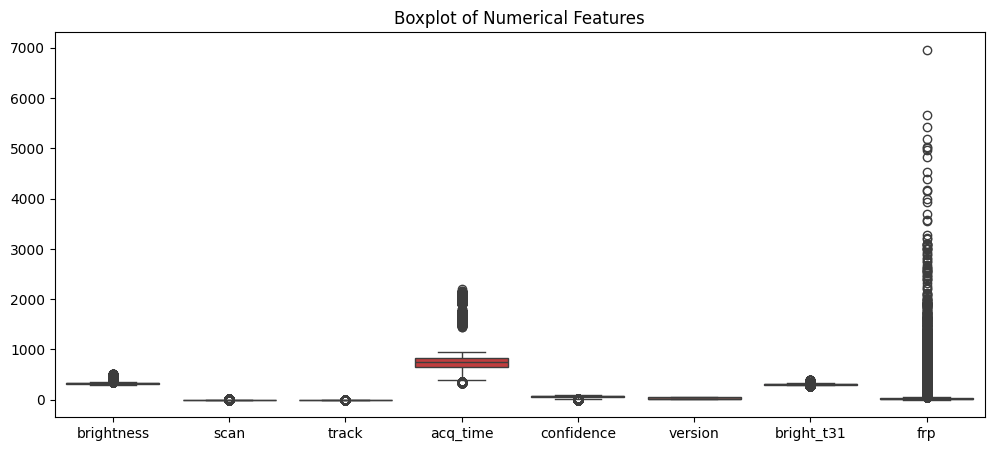

In [348]:
# Visualize outliers using boxplot for key numerical features
plt.figure(figsize=(12,5))
plt.title('Boxplot of Numerical Features')
sns.boxplot(data=df[numerical_cols])
plt.show()

In [349]:
# Create a function to remove outliers
# Using IQR Method

def remove_outliers(df, column):
  Q1 = df[column].quantile(0.25)
  Q3 = df[column].quantile(0.75)
  IQR = Q3 - Q1
  lower_bound = Q1 - 1.5 * IQR
  upper_bound = Q3 + 1.5 * IQR

  df_clean = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
  return df_clean

In [350]:
# Apply outlier function to columns

for columns in numerical_cols:
  df = remove_outliers(df, columns)

In [351]:
df.shape

(189370, 20)

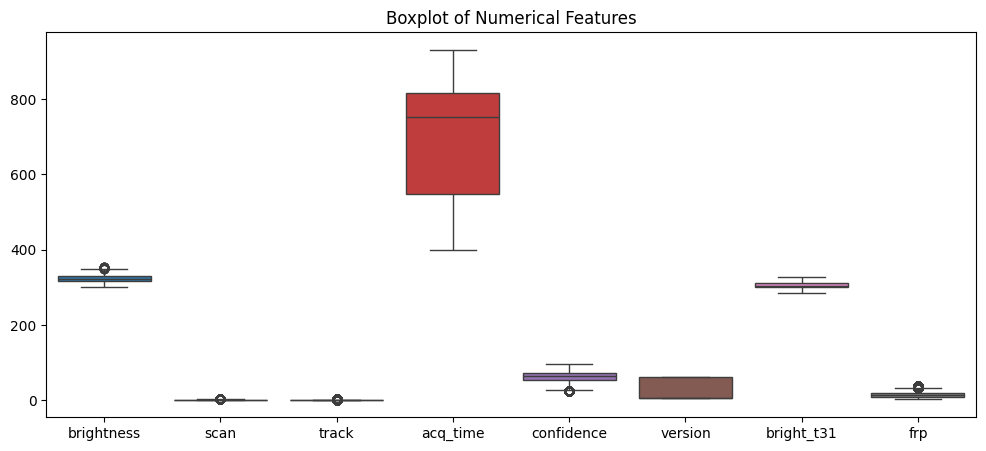

In [352]:
# Visualize boxplot after outlier removal

plt.figure(figsize=(12,5))
plt.title('Boxplot of Numerical Features')
sns.boxplot(data=df[numerical_cols])
plt.show()

In [353]:
df.head()

,latitude,longitude,brightness,scan,track,acq_date,acq_time,satellite,instrument,confidence,version,bright_t31,frp,daynight,type,year,month,dayofweek,dayofyear,hour
0,28.0993,96.9983,303.0,1.1,1.1,2021-01-01,409,Terra,MODIS,44,6.03,292.6,8.6,D,0,2021,1,4,1,40
1,30.0420,79.6492,301.8,1.4,1.2,2021-01-01,547,Terra,MODIS,37,6.03,287.4,9.0,D,0,2021,1,4,1,54
3,30.0408,80.0501,302.0,1.5,1.2,2021-01-01,547,Terra,MODIS,46,6.03,287.7,10.7,D,0,2021,1,4,1,54
4,30.6565,78.9668,300.9,1.3,1.1,2021-01-01,547,Terra,MODIS,43,6.03,287.6,9.0,D,0,2021,1,4,1,54
6,31.4366,76.8988,300.5,1.0,1.0,2021-01-01,547,Terra,MODIS,36,6.03,287.2,5.3,D,0,2021,1,4,1,54


In [354]:
# Count values of 'Type' column
df['type'].value_counts()

,count
type,
0,182841
2,6501
3,28


In [355]:
# Define categorical cols
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

In [356]:
categorical_cols

['satellite', 'instrument', 'daynight']

In [357]:
for col in categorical_cols:
    print(f"Value counts for column: {col}")
    print(df[col].unique())
    print("-" * 30)

Value counts for column: satellite
['Terra' 'Aqua']
------------------------------
Value counts for column: instrument
['MODIS']
------------------------------
Value counts for column: daynight
['D']
------------------------------


If using One Hot Encoding

When you run:

df = pd.get_dummies(df, columns=categorical_cols)

If a column has only one unique value or two values and you used drop_first=True, the result might drop it entirely.

When you omit drop_first, Pandas by default returns Boolean (True / False) values in the dummy columns only if the original column is of boolean type or has only two unique values (like 'yes'/'no', 'male'/'female', etc.). Internally, these columns can still work like binary, but they are just of bool type instead of int.

In [358]:
# Apply Label Encoding
df_encoded = df.copy()

for col in categorical_cols:
  le = LabelEncoder()
  df_encoded[col] = le.fit_transform(df[col])

In [359]:
df_encoded.head()

,latitude,longitude,brightness,scan,track,acq_date,acq_time,satellite,instrument,confidence,version,bright_t31,frp,daynight,type,year,month,dayofweek,dayofyear,hour
0,28.0993,96.9983,303.0,1.1,1.1,2021-01-01,409,1,0,44,6.03,292.6,8.6,0,0,2021,1,4,1,40
1,30.0420,79.6492,301.8,1.4,1.2,2021-01-01,547,1,0,37,6.03,287.4,9.0,0,0,2021,1,4,1,54
3,30.0408,80.0501,302.0,1.5,1.2,2021-01-01,547,1,0,46,6.03,287.7,10.7,0,0,2021,1,4,1,54
4,30.6565,78.9668,300.9,1.3,1.1,2021-01-01,547,1,0,43,6.03,287.6,9.0,0,0,2021,1,4,1,54
6,31.4366,76.8988,300.5,1.0,1.0,2021-01-01,547,1,0,36,6.03,287.2,5.3,0,0,2021,1,4,1,54


In [360]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Index: 189370 entries, 0 to 271207
Data columns (total 20 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   latitude    189370 non-null  float64       
 1   longitude   189370 non-null  float64       
 2   brightness  189370 non-null  float64       
 3   scan        189370 non-null  float64       
 4   track       189370 non-null  float64       
 5   acq_date    189370 non-null  datetime64[ns]
 6   acq_time    189370 non-null  int64         
 7   satellite   189370 non-null  int64         
 8   instrument  189370 non-null  int64         
 9   confidence  189370 non-null  int64         
 10  version     189370 non-null  float64       
 11  bright_t31  189370 non-null  float64       
 12  frp         189370 non-null  float64       
 13  daynight    189370 non-null  int64         
 14  type        189370 non-null  int64         
 15  year        189370 non-null  int32         
 16  month  

In [362]:
!pip install folium
import folium

# Create map and sample data
india_map = folium.Map(location=[22.351115, 78.667743], zoom_start=5)
sample_df = df_encoded.sample(n=min(10000, len(df_encoded)), random_state=42)

# Add markers
for _, row in sample_df.iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=3,
        color='red',
        fill=True,
        fill_opacity=0.6,
        popup=f"FRP: {row['frp']:.2f}, Date: {row['acq_date'].strftime('%Y-%m-%d')}"
    ).add_to(india_map)

# Save Map
india_map.save('india_map.html')

# Feature Scaling

In [363]:
scaler = StandardScaler()
numerical_cols = ['brightness', 'scan', 'track', 'acq_time','confidence', 'version', 'bright_t31', 'frp']
df_encoded[numerical_cols] = scaler.fit_transform(df_encoded[numerical_cols])

In [364]:
df_encoded.head()

,latitude,longitude,brightness,scan,track,acq_date,acq_time,satellite,instrument,confidence,version,bright_t31,frp,daynight,type,year,month,dayofweek,dayofyear,hour
0,28.0993,96.9983,-2.308455,-0.464860,0.059274,2021-01-01,-2.248393,1,0,-1.319370,-0.645357,-1.754135,-0.735900,0,0,2021,1,4,1,40
1,30.0420,79.6492,-2.445530,0.588678,0.936416,2021-01-01,-1.209513,1,0,-1.818736,-0.645357,-2.471213,-0.683381,0,0,2021,1,4,1,54
3,30.0408,80.0501,-2.422684,0.939857,0.936416,2021-01-01,-1.209513,1,0,-1.176694,-0.645357,-2.429843,-0.460175,0,0,2021,1,4,1,54
4,30.6565,78.9668,-2.548336,0.237499,0.059274,2021-01-01,-1.209513,1,0,-1.390708,-0.645357,-2.443633,-0.683381,0,0,2021,1,4,1,54
6,31.4366,76.8988,-2.594027,-0.816039,-0.817867,2021-01-01,-1.209513,1,0,-1.890074,-0.645357,-2.498792,-1.169182,0,0,2021,1,4,1,54


## Features Target Split

In [365]:
features = ['brightness', 'scan', 'track', 'confidence', 'bright_t31', 'frp']
target = 'type'

x = df_encoded[features]
y = df_encoded[target]

In [366]:
print(x)

        brightness      scan     track  confidence  bright_t31       frp
0        -2.308455 -0.464860  0.059274   -1.319370   -1.754135 -0.735900
1        -2.445530  0.588678  0.936416   -1.818736   -2.471213 -0.683381
3        -2.422684  0.939857  0.936416   -1.176694   -2.429843 -0.460175
4        -2.548336  0.237499  0.059274   -1.390708   -2.443633 -0.683381
6        -2.594027 -0.816039 -0.817867   -1.890074   -2.498792 -1.169182
...            ...       ...       ...         ...         ...       ...
271199   -0.423680  1.642216  1.813557   -0.605991    0.369517  0.327610
271200   -0.846327  3.398112  2.690698   -1.319370   -0.085551  0.209442
271201   -0.789212  1.993395  1.813557   -1.105356   -0.306191 -0.079412
271204   -0.115262  1.993395  1.813557    0.678093    0.093718  1.679975
271207   -1.051939  0.237499  0.059274   -0.605991   -0.223451 -0.985366

[189370 rows x 6 columns]


In [367]:
print(y)

0         0
1         0
3         0
4         0
6         0
         ..
271199    0
271200    0
271201    0
271204    0
271207    0
Name: type, Length: 189370, dtype: int64


In [368]:
y.value_counts()

,count
type,
0,182841
2,6501
3,28


In [369]:
# Theres imbalance of data. 0 is majority data which can cause bias when predictting
# Use techniques like re-sampling(up/down), K-Fold CV, Smote(over sampling) to balance the data

In [370]:
# Initialize smote
smote = SMOTE(random_state=42)

# Apply SMOTE to x, y
x_resampled, y_resampled = smote.fit_resample(x, y)

# Check distribution of target variable after resampling
print(y_resampled.value_counts())

type
0    182841
2    182841
3    182841
Name: count, dtype: int64
